In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'bwr'

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

df = pd.read_csv('train.csv')
print(df.shape)

y = df.label

X = df.drop('label',axis=1)
X = X/255
X = X.values.reshape(len(X),img_rows,img_cols,1)


del df

(42000, 785)
[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]
  [ 0. 

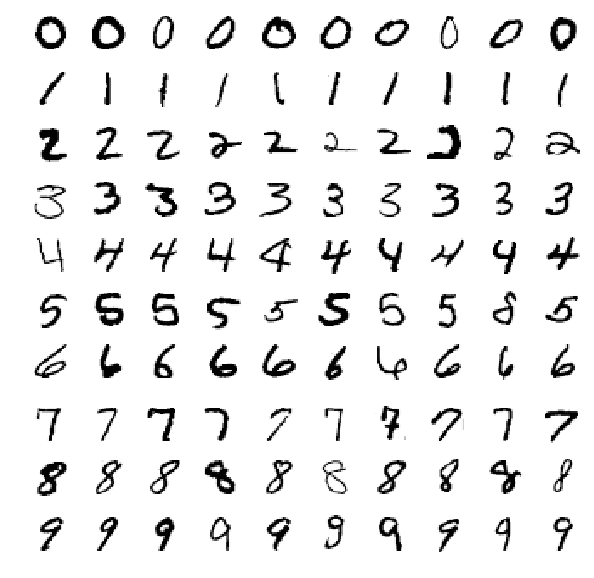

In [3]:
plt.figure(figsize=(10,10))
for i in range(10):
    tmp = X[y==i]
    for j in range(10):
        plt.subplot(10,10,(10*i)+(j+1))
        plt.imshow(tmp[j][:,:,0], cmap='Greys')
        plt.clim(0,1)
        plt.axis('off')

In [4]:
y = keras.utils.to_categorical(y, num_classes)
print(y.shape)
print(y[0])

(42000, 10)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [5]:
n_filters = 12

model = Sequential()
model.add(Conv2D(n_filters, kernel_size=(3, 3), activation='relu',
                 input_shape=(img_rows, img_cols, 1),name='conv1'))
model.add(Conv2D(n_filters, kernel_size=(3, 3), activation='relu',name='conv2'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          batch_size=100,
          epochs=3,
          validation_split = 0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 57s 2ms/step - loss: 0.2307 - acc: 0.9338 - val_loss: 0.0928 - val_acc: 0.9700
Epoch 2/3
33600/33600 [==============================] - 55s 2ms/step - loss: 0.0679 - acc: 0.9800 - val_loss: 0.0655 - val_acc: 0.9801
Epoch 3/3
33600/33600 [==============================] - 53s 2ms/step - loss: 0.0420 - acc: 0.9871 - val_loss: 0.0573 - val_acc: 0.9817


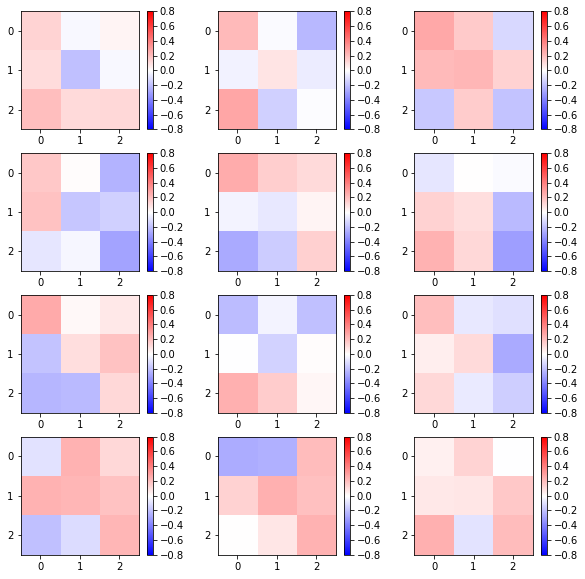

In [6]:
tmp=model.get_layer('conv1').get_weights()[0]
plt.figure(figsize=(10,10))
for i in range(n_filters):
    plt.subplot(4,3,i+1)
    plt.imshow(tmp[:,:,0,i],cmap='bwr')
    plt.clim(-0.8,0.8)
    plt.colorbar()

In [7]:
model_conv1=Sequential()
model_conv1.add(model.get_layer('conv1'))
model_conv1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
conv1_out = model_conv1.predict(X)
print(conv1_out.shape)

model_conv2=Sequential()
model_conv2.add(model.get_layer('conv1'))
model_conv2.add(model.get_layer('conv2'))
model_conv2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
conv2_out = model_conv2.predict(X)
print(conv2_out.shape)

(42000, 26, 26, 12)
(42000, 24, 24, 12)


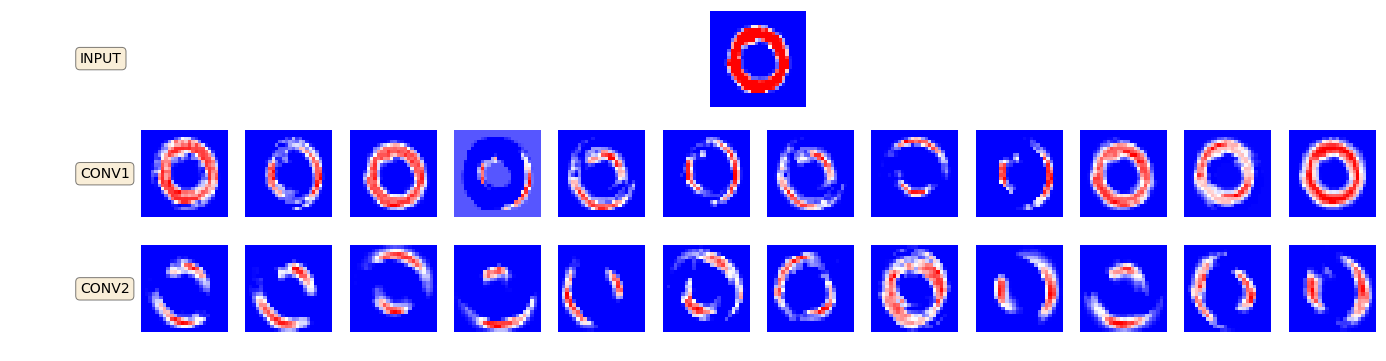

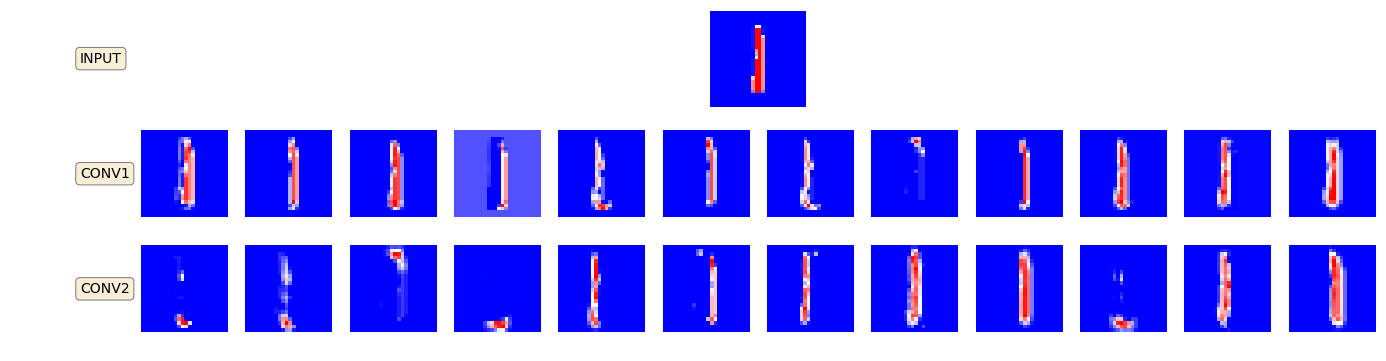

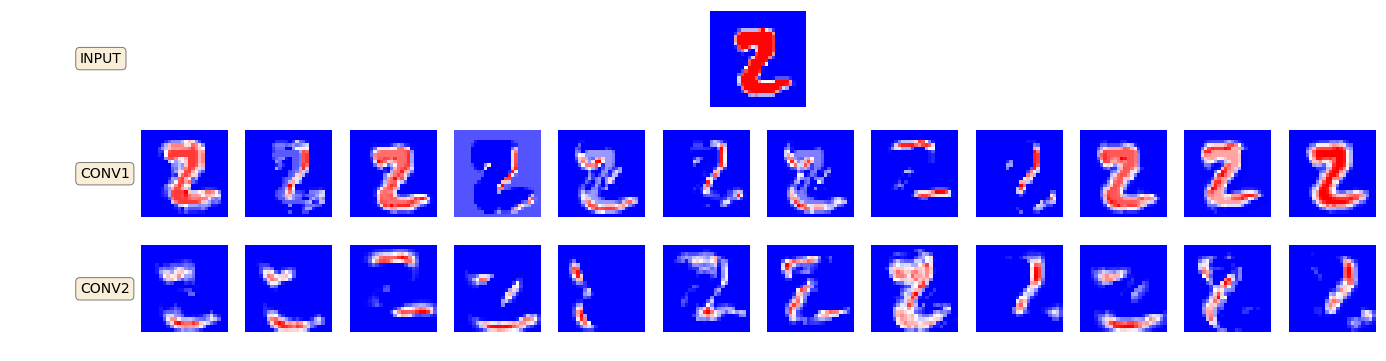

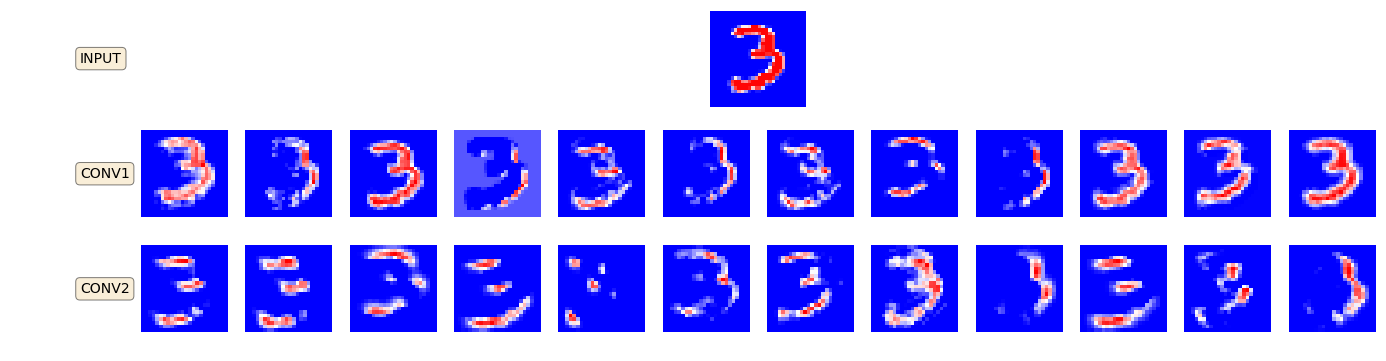

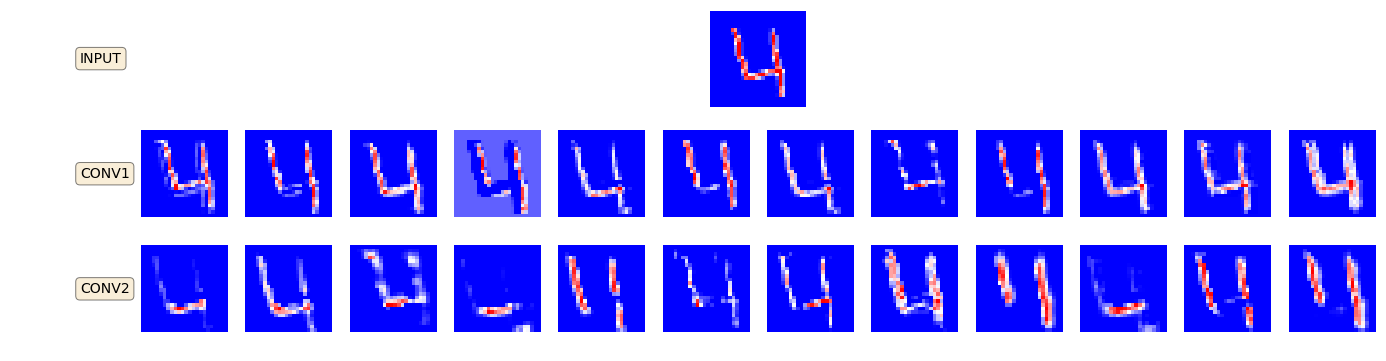

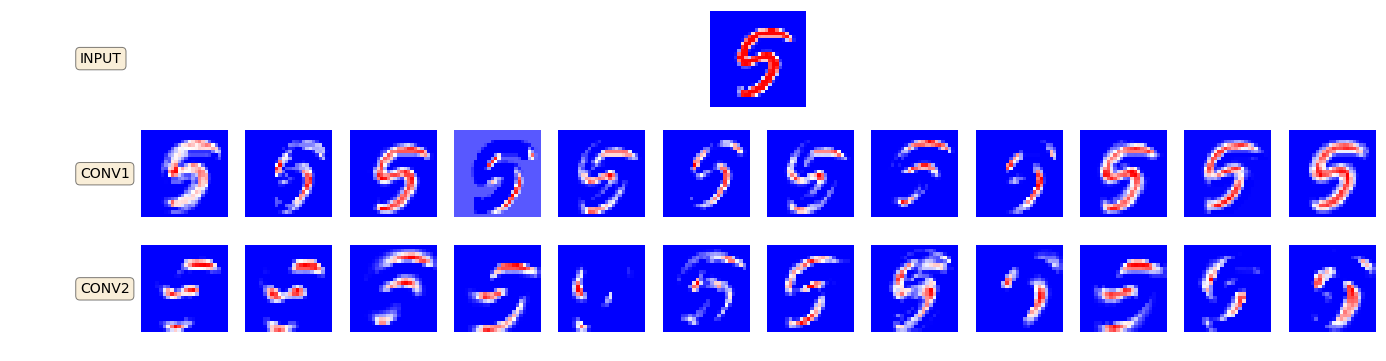

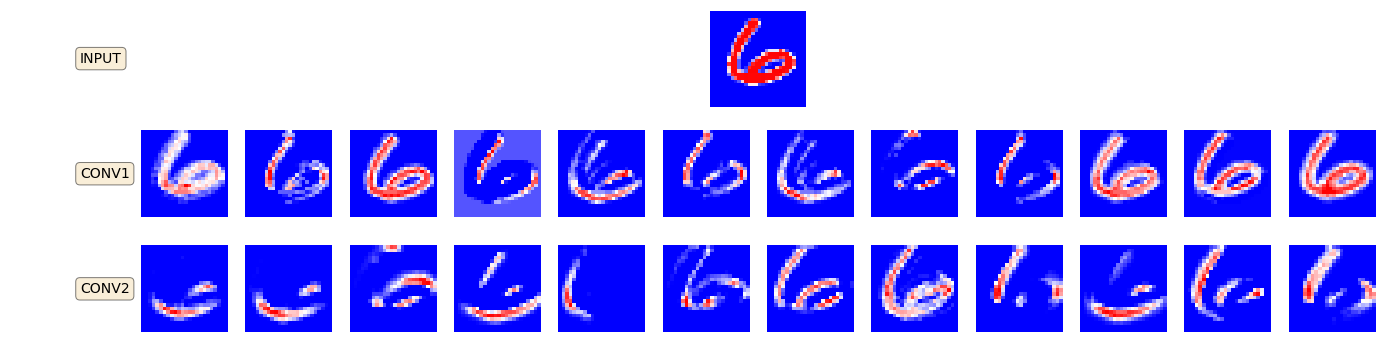

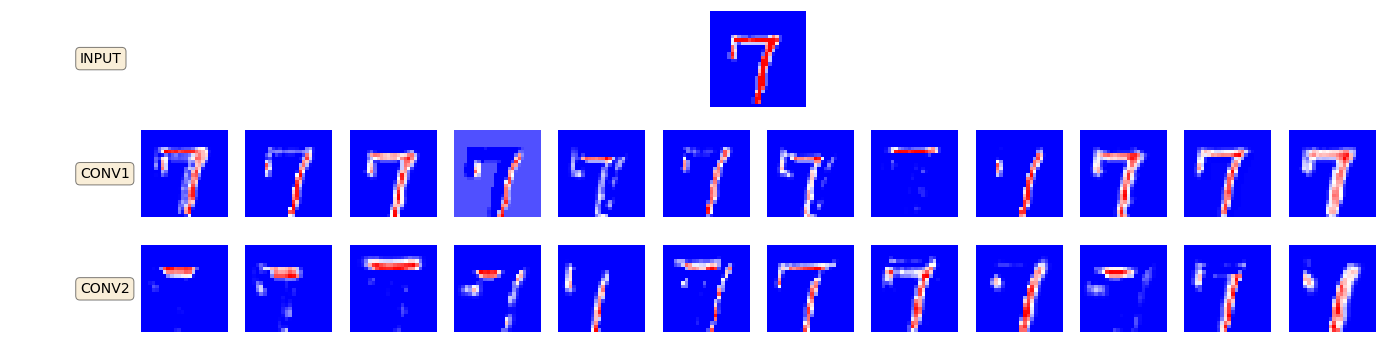

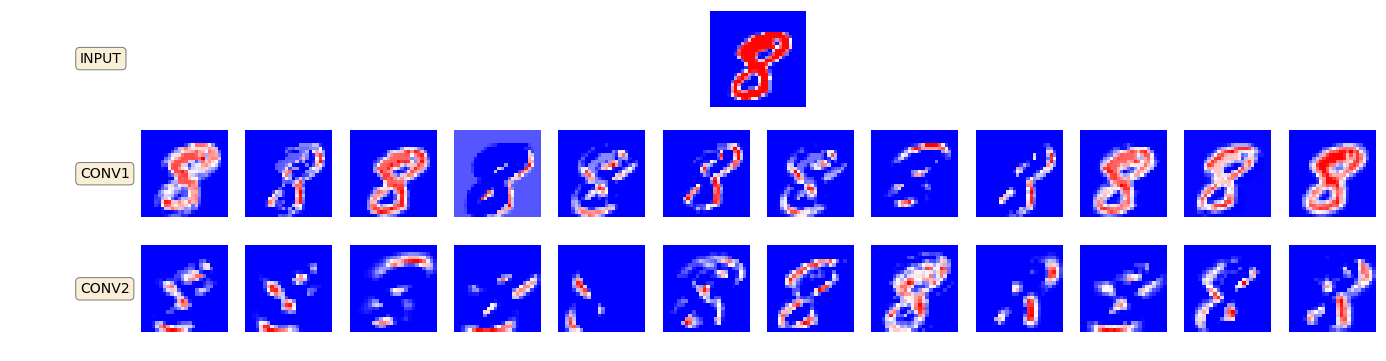

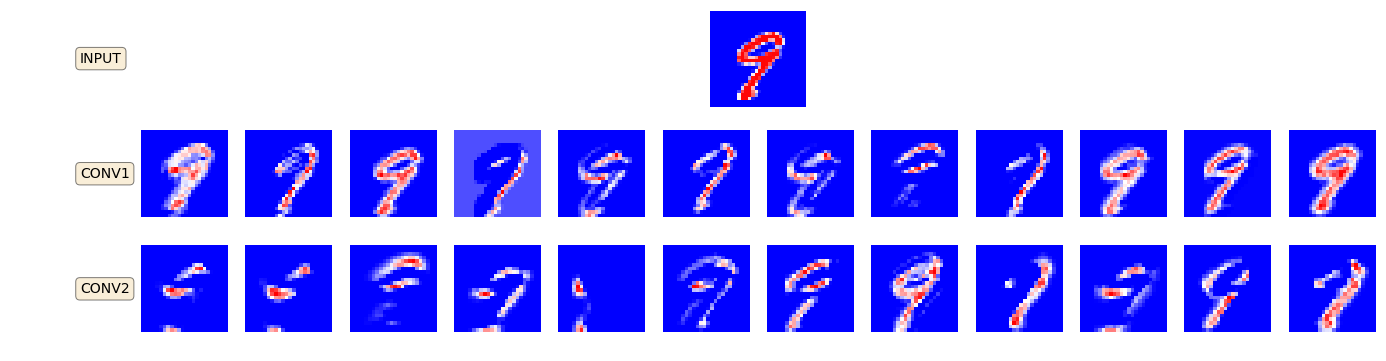

In [17]:
plot_imgs = [1,2,16,9,3,8,72,6,10,11]

for img_id in plot_imgs:
    plt.figure(figsize=(24,6))

    # place a text box in upper left in axes coords
    ax = plt.subplot(3,n_filters+1,1)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'INPUT', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # place a text box in upper left in axes coords
    ax = plt.subplot(3,n_filters+1,n_filters+2)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'CONV1', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    # place a text box in upper left in axes coords
    ax = plt.subplot(3,n_filters+1,2*n_filters+3)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'CONV2', verticalalignment='center',fontsize=14,bbox=props)
    plt.axis('off')

    plt.subplot2grid((3, n_filters+1), (0, int(n_filters/3)+1), colspan=int(n_filters/3))
    plt.imshow(X[img_id][:,:,0])
    plt.clim(0,1)
    plt.axis('off')

    for i in range(n_filters):
        plt.subplot(3,n_filters+1,i+3+n_filters)
        plt.imshow(conv1_out[img_id,:,:,i])
        plt.axis('off')

    for i in range(n_filters):
        plt.subplot(3,n_filters+1,i+4+2*n_filters)
        plt.imshow(conv2_out[img_id,:,:,i])
        plt.axis('off')